In [3]:
# basic python libraries
import numpy as np
import pandas as pd
## For plotting
from numpy import meshgrid
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from spectral_cube import SpectralCube
from spectral_cube import Projection 


from astropy.wcs import WCS
from astropy.wcs import utils 
from astropy.table import QTable
from astropy import constants as con
from astropy import units as u

# Support Vector Regression for 12CO/21cm + flat-spectrum
- This is done with standardized transformation of the variables involved 
- Excess zeros are not treated differently 

In [4]:
import os
working_directory = os.getcwd()
print(working_directory)

/Volumes/GoogleDrive/My Drive/0.Work/RESEARCH_INFO/Research_2021/PilotSurvey_Newfields/Large-sample-outflows-in-CygX-and-ML-methods/notebooks


# 1. Exploratory Data Analysis 

In [35]:
proto_co_df = pd.read_csv('./../data/co+21cm_flat49.csv')
del proto_co_df['Unnamed: 0']

# avoid writing unnamed column when creating csv file from dataframe >>> df.to_csv('file.csv', index=False)
print(proto_co_df.sort_values('21cm(K)').head(10),'\n =========================================')
print('EDA ---------------------- \n')
print(proto_co_df.describe())
print('correlation matrix with NaN values: \n',proto_co_df.corr())
print('=========================================')
print('correlation matrix w/o NaN values: \n',proto_co_df.dropna().corr())
print('=========================================')
print('correlation matrix w/o NaN values and highest co value: \n')
print(proto_co_df.dropna().sort_values('12CO(K km/s)', ascending=True).iloc[:-1].corr())

    12CO(K km/s)   21cm(K)  proto_flat_number
20      0.207122  8.055683                0.0
27      1.652198  8.575341                0.0
34      0.666847  8.778970                0.0
13           NaN  8.814948                0.0
41           NaN  9.004439                0.0
48           NaN  9.365131                0.0
40           NaN  9.384368                0.0
47           NaN  9.551334                0.0
5            NaN  9.581038                0.0
12           NaN  9.857984                0.0 
EDA ---------------------- 

       12CO(K km/s)    21cm(K)  proto_flat_number
count     33.000000  49.000000          49.000000
mean       3.387244  14.837098           8.448980
std        3.635216   5.217170          12.295089
min        0.207122   8.055683           0.000000
25%        1.245347  10.610548           0.000000
50%        1.994775  13.182066           3.000000
75%        4.224709  18.295208          12.000000
max       17.986933  29.544397          57.000000
correlation ma

# 2. Handling Missing Values

- SInce we have a significant number of missing co data we can not simply remove those rows, which can lead to data leakage. 
- We use replacement values. There are a few ways to do that including average, max, most frequent number (better for a pure classification problem), etc. I choose to use iterative imputaiton which is basically regressing missing co values based on associated 21cm and target values.  
- First, I do this without interaction term, and then with interaction term

In [80]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Setting the random_state argument for reproducibility
imputer = IterativeImputer(random_state=42)
imputed = imputer.fit_transform(proto_co_df) #[['12CO(K km/s)', '21cm(K)']
proto_df_imputed = pd.DataFrame(imputed, columns=proto_co_df.columns)

print(round(proto_df_imputed.sort_values('proto_flat_number'), 10).head(5))
print('Correlation matrix after imputation w/o interaction')
print(proto_df_imputed.corr())

    12CO(K km/s)    21cm(K)  proto_flat_number
48      1.277917   9.365131                0.0
26      1.427586  16.668314                0.0
20      0.207122   8.055683                0.0
19      0.658326  11.318258                0.0
18      0.413414  12.469313                0.0
Correlation matrix after imputation w/o interaction
                   12CO(K km/s)   21cm(K)  proto_flat_number
12CO(K km/s)           1.000000  0.567602           0.821444
21cm(K)                0.567602  1.000000           0.653646
proto_flat_number      0.821444  0.653646           1.000000


# 2b. Imputation with interaction 

In [83]:
features = ['12CO(K km/s)','21cm(K)']
target = ['proto_flat_number']
proto_df_imputed_inter = proto_df_imputed.copy()#.drop('Unnamed: 0')
proto_df_imputed_inter['12CO_21cm'] = proto_df_imputed_inter['12CO(K km/s)'] * proto_df_imputed_inter['21cm(K)']
  
print('Correlation matrix after imputation with interaction')
print(proto_inter_df_imputed.corr())
proto_df_imputed_inter

Correlation matrix after imputation with interaction
                   12CO(K km/s)   21cm(K)  proto_flat_number  12CO_21cm
12CO(K km/s)           1.000000  0.601785           0.810954   0.975801
21cm(K)                0.601785  1.000000           0.653646   0.674238
proto_flat_number      0.810954  0.653646           1.000000   0.849340
12CO_21cm              0.975801  0.674238           0.849340   1.000000


12CO(K km/s)    21cm(K)  proto_flat_number   12CO_21cm
0       2.805552  18.298695                6.0   51.337934
1       2.390023  23.062265                3.0   55.119337
2       1.257737  14.927852                3.0   18.775314
3       6.872768  12.604801                1.0   86.629873
4       0.616750  10.279692                0.0    6.339999
5       1.286064   9.581038                0.0   12.321825
6       1.339182  10.988778                0.0   14.715972
7       2.968321  22.612419                6.0   67.120924
8       1.856782  29.544397                5.0   54.857511
9       3.551901  19.648626                7.0   69.789978
10      1.994775  15.061070               12.0   30.043449
11      1.035460  12.336997                0.0   12.774470
12      1.296514   9.857984                0.0   12.781010
13      1.257157   8.814948                0.0   11.081772
14      8.384427  24.166828               33.0  202.625009
15      3.225581  23.003414               20.0   74.199385
16      1.282782  15.655737               22.0   20.082893
17      1.124471  13.182066                1.0   14.822847
18      0.413414  12.469313                0.0    5.154988
19      0.658326  11.318258                0.0    7.451101
20      0.207122   8.055683                0.0    1.668506
21      5.611143  19.031555               20.0  106.788787
22      6.139794  17.214018               39.0  105.690530
23      1.999865  18.295208               23.0   36.587951
24      0.523022  13.782497                3.0    7.208551
25      2.737947  14.314290                0.0   39.191774
26      1.427586  16.668314                0.0   23.795445
27      1.652198   8.575341                0.0   14.168164
28      5.736006  17.082020               21.0   97.982568
29      1.463250  17.748304                8.0   25.970213
30      5.882566  21.594070               25.0  127.028554
31      9.217491  21.756325               24.0  200.538731
32      5.506907  13.415506                6.0   73.877946
33      2.583126  12.478484                0.0   32.233492
34      0.666847   8.778970                0.0    5.854226
35      3.003324  13.022779                8.0   39.111630
36      3.953170  12.007515                2.0   47.467743
37      8.898359  18.824352               22.0  167.505850
38     17.986933  25.364428               57.0  456.228253
39      2.550689  11.571168                7.0   29.514451
40      1.278643   9.384368                0.0   11.999253
41      1.264307   9.004439                0.0   11.384374
42      1.920183  10.610548                3.0   20.374190
43      1.245347   9.943192                1.0   12.382724
44      1.436471  11.233647                0.0   16.136804
45      7.584892  18.100367               19.0  137.289331
46      4.224709  12.828786                7.0   54.197882
47      1.284943   9.551334                0.0   12.272918
48      1.277917   9.365131                0.0   11.967859

# 3. Scatter plot with and w/o interaction 

<Figure size 864x864 with 0 Axes>

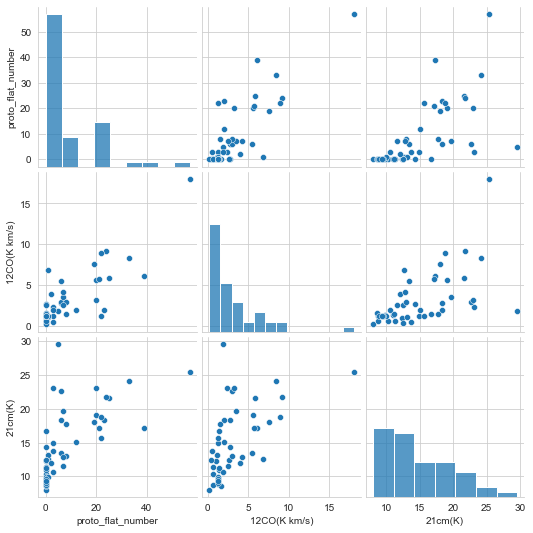

<Figure size 864x864 with 0 Axes>

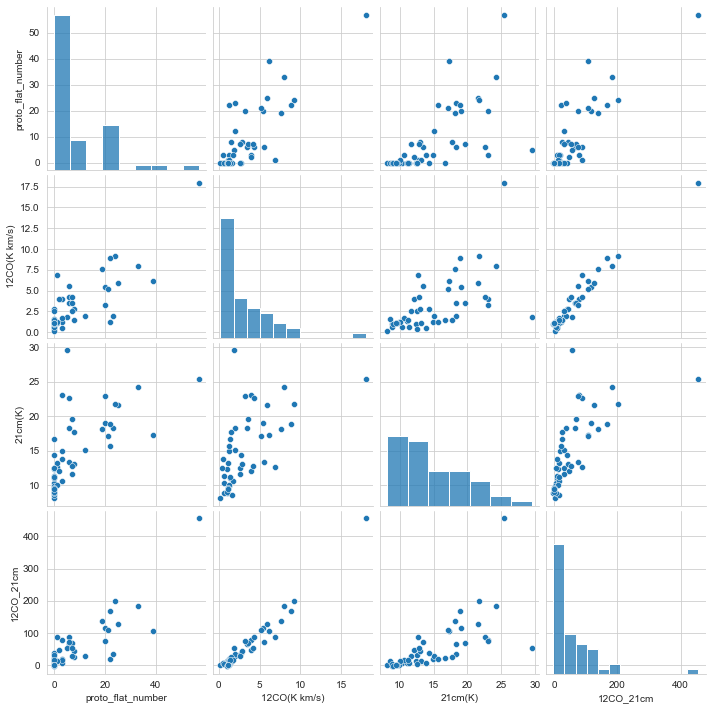

In [73]:
#sns.pairplot(proto_co_df_inter[['proto_flat_number','12CO(K km/s)', '21cm(K)', '12CO_21cm']])
plt.figure(figsize=(12,12))
sns.pairplot(proto_df_imputed[['proto_flat_number','12CO(K km/s)', '21cm(K)']])
plt.show()
plt.close()

plt.figure(figsize=(12,12))
sns.pairplot(proto_inter_df_imputed[['proto_flat_number','12CO(K km/s)', '21cm(K)', '12CO_21cm']])
plt.show()
plt.close()

21cm max: 29.544397354125977


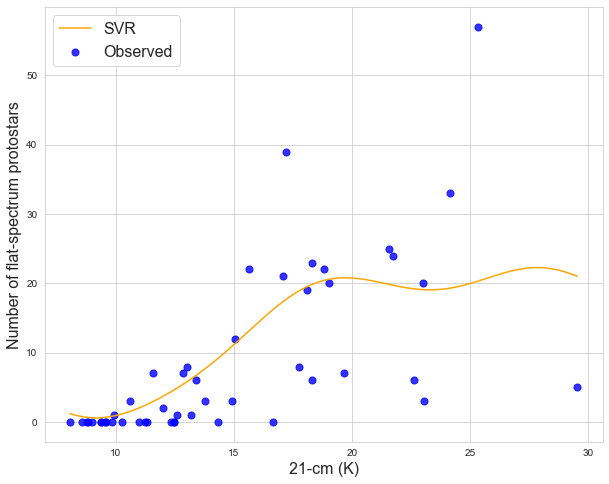

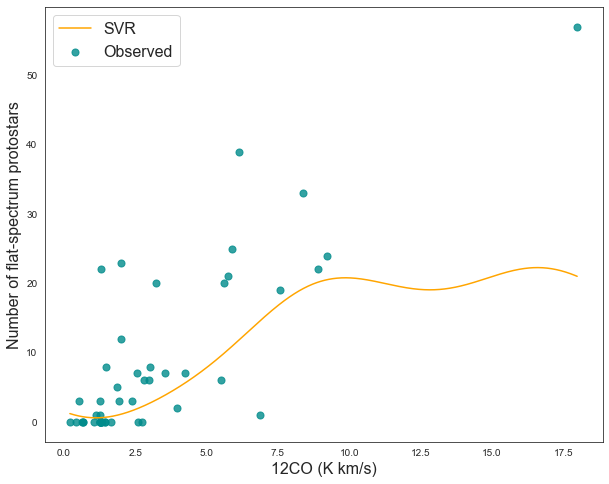

array([], dtype=float64)

In [74]:
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')

#proto_co_df_inter = proto_co_df_inter.loc[proto_co_df_inter[target] > 0, :]
features1 = ['12CO(K km/s)','21cm(K)', '12CO_21cm']
#Xf = proto_co_df_inter[features1]
proto_co_df = proto_df_imputed


X = proto_co_df[features]
y = np.array(proto_co_df[target])#.reshape(-1,1)
print('21cm max:',X['21cm(K)'].max())

sc_X1 = StandardScaler()
sc_X2 = StandardScaler()
#sc_Xf = StandardScaler()
sc_y = StandardScaler()

X1 = sc_X1.fit_transform(np.array(X)[:,0].reshape(-1,1))
X2 = sc_X2.fit_transform(np.array(X)[:,1].reshape(-1,1))
#Xf = sc_Xf.fit_transform(np.array(Xf)[:,2].reshape(-1,1))

X_ = np.concatenate([X1,X2], axis=1)
#Xf_ = np.concatenate([X1,X2,Xf], axis=1)

y_ = sc_y.fit_transform(y).reshape(-1)

from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf',degree=3, gamma='scale')
regressor.fit(X_, y_)


y_pred = regressor.predict(X_)
y_pred = sc_y.inverse_transform(y_pred.reshape(-1,1)) 


x1 = np.linspace((X_[:,0]).min(), X_[:,0].max(), 1000)
x2 = np.linspace((X_[:,1]).min(), X_[:,1].max(), 1000)
x1x2 = np.concatenate([x1.reshape(-1,1),x2.reshape(-1,1)], axis=1)

Z = regressor.predict(x1x2)
Z = sc_y.inverse_transform(Z.reshape(-1,1)) 
                 
#from matplotlib import cm
#X1 = X[:,0]
#X2 = X


#x1 = np.linspace(X1.min(), X1.max(), 20)
#x2 = np.linspace(X2.min(), X2.max(), 20)

#y = np.array(proto_co_df[target])
#z = y_pred.reshape(-1,)
#x1_, x2_= np.meshgrid(x1, x2)
#y_pred = pr.predict(x1_, x2_)
#X_grid = np.concatenate([x1_.reshape(-1,1), x2_.reshape(-1,1)], axis=1)


#pred_grid = regressor.predict(X_grid)
#Xz_grid = np.concatenate([X_grid, pred_grid.reshape(-1,1)], axis=1)
fig = plt.figure(figsize=(10,8))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(Xz_grid[:,0], Xz_grid[:,1], Xz_grid[:,2])
plt.scatter(sc_X2.inverse_transform(X_[:,1].reshape(-1,1)), y, 
                                                        color='blue', s=50, alpha=0.8, label='Observed')
plt.plot(sc_X2.inverse_transform(x1x2[:,1].reshape(-1,1)), Z,'orange', label='SVR')
plt.ylabel('Number of flat-spectrum protostars', fontsize=16)
plt.xlabel('21-cm (K)', fontsize=16)
plt.legend(fontsize=16)
#plt.savefig('21cm_flatspectrum_SVR.pdf')
plt.show()
plt.close()

sns.set_style('white')
fig = plt.figure(figsize=(10,8))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(Xz_grid[:,0], Xz_grid[:,1], Xz_grid[:,2])
plt.scatter(sc_X1.inverse_transform(X_[:,0].reshape(-1,1)), y,
                                                            color='darkcyan', s=50, alpha=0.8, label='Observed')
plt.plot(sc_X1.inverse_transform(x1x2[:,0].reshape(-1,1)), Z,'orange', label='SVR')
plt.ylabel('Number of flat-spectrum protostars', fontsize=16)
plt.xlabel('12CO (K km/s)', fontsize=16)
plt.legend(fontsize=16)
#plt.savefig('12co_flatspectrum_SVR.pdf')
plt.show()
plt.close()

regressor.class_weight_

# Support Vector Classifier with Linear regressor 
- Zero Inflated Regression checks if the output is zero or not
- Gaussian kernel for the classifier
- for non zero output fit a linear regressor (polynomial)
- outflow number is not standardized 
- class_weight='balanced' takes care of imbalance by assigning class weight proportional to number of classes

In [50]:
poly = PolynomialFeatures(2,interaction_only=False, include_bias=True)
poly.fit(X_)
X_poly = poly.transform(X_)
print(X_poly.shape)

NameError: name 'PolynomialFeatures' is not defined

(49, 6)


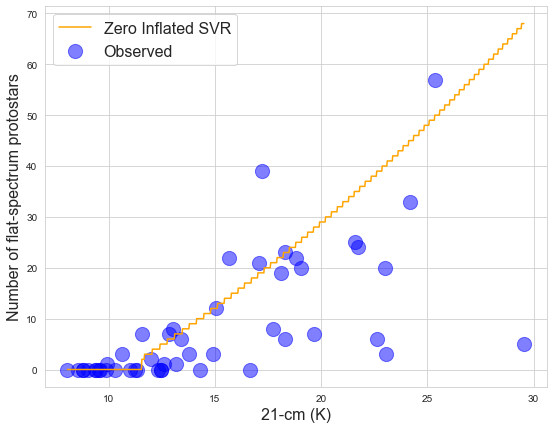

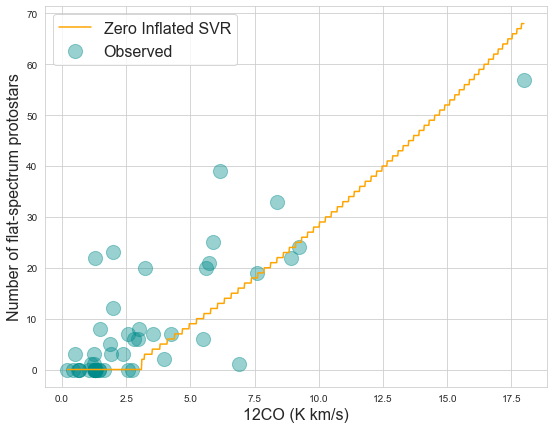

In [169]:
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, PoissonRegressor
from zero_inflated_regressor import ZeroInflatedRegressor
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2,interaction_only=False, include_bias=True)
poly.fit(X_)
X_poly = poly.transform(X_)
print(X_poly.shape)
zir = ZeroInflatedRegressor(classifier=SVC(kernel='rbf', class_weight='balanced'),regressor=LinearRegression())
#zir = ZeroInflatedRegressor(classifier=SVC(kernel='rbf', class_weight='balanced'),regressor=PolynomialFeatures(3))

y = np.array(proto_co_df[target]).reshape(-1)
zir.fit(X_poly, y)
y_pred_zir = zir.predict(poly.fit_transform(X_))

x1 = np.linspace((X_[:,0]).min(), X_[:,0].max(), 1000)
x2 = np.linspace((X_[:,1]).min(), X_[:,1].max(), 1000)
x1x2 = np.concatenate([x1.reshape(-1,1),x2.reshape(-1,1)], axis=1)

Zir = zir.predict(poly.fit_transform(x1x2))
#Zir = sc_y.inverse_transform(Zir.reshape(-1,1)) 

sns.set_style('whitegrid')
fig = plt.figure(figsize=(9,7))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(Xz_grid[:,0], Xz_grid[:,1], Xz_grid[:,2])
plt.scatter(sc_X2.inverse_transform(X_[:,1].reshape(-1,1)), y,marker='o',
                                                            color='blue', s=200, alpha=0.5, label='Observed')
plt.plot(sc_X2.inverse_transform(x1x2[:,1].reshape(-1,1)),np.round(Zir),'orange', label='Zero Inflated SVR')
plt.ylabel('Number of flat-spectrum protostars', fontsize=16)
plt.xlabel('21-cm (K)', fontsize=16)
plt.legend(fontsize=16)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig('21cm_flatspectrum_ZSVR.pdf')
plt.show()
plt.close()


sns.set_style('whitegrid')
fig = plt.figure(figsize=(9,7))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(Xz_grid[:,0], Xz_grid[:,1], Xz_grid[:,2])
plt.scatter(sc_X1.inverse_transform((X_[:,0]).reshape(-1,1)), y, marker='o',
                                                            color='darkcyan', s=200, alpha=0.4, label='Observed')
plt.plot(sc_X1.inverse_transform((x1x2[:,0]).reshape(-1,1)),np.round(Zir),'orange', label='Zero Inflated SVR')
#plt.plot(sc_X1.inverse_transform(X_[:,0].reshape(-1,1)),y_pred_zir,'orange', label='SVR')
plt.ylabel('Number of flat-spectrum protostars', fontsize=16)
plt.xlabel('12CO (K km/s)', fontsize=16)
plt.legend(fontsize=16)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig('12co_flatspectrum_ZSVR.pdf')
plt.show()
plt.close()



RMSE= 30.89580788789161


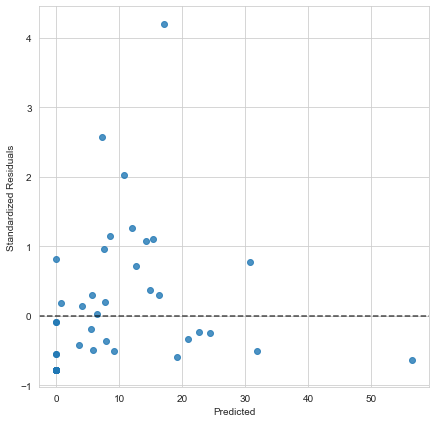

In [76]:
res = np.abs(y_pred_zir - y)
print('RMSE=', (res**2).sum()/len(res))
import scipy.stats as stats
plt.figure(figsize=(7,7))
plt.axhline(y=0, linestyle='--', color='k', alpha=0.7)
plt.scatter(y_pred_zir, stats.zscore(res), alpha=0.8)#,s=10, marker='+', color='g', alpha=1)
#plt.plot(pred, stats.zscore(res),marker='.')
plt.xlabel('Predicted')
plt.ylabel('Standardized Residuals')
plt.show()

In [125]:
x1x2.shape, X1X1.shape

((1, 80000), (200, 200))

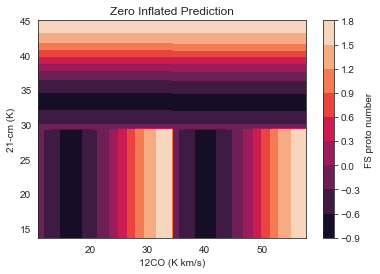

In [123]:
# get a grid of x1 values
x1x1 = np.linspace(sc_X1.inverse_transform(X_[:,0].reshape(-1,1)).min(), 
                   sc_X1.inverse_transform(X_[:,0].reshape(-1,1)).max(), 200)

# get a grid of x2 values
x2x2 = np.linspace(sc_X2.inverse_transform(X_[:,1].reshape(-1,1)).min(), 
                   sc_X2.inverse_transform(X_[:,1].reshape(-1,1)).max(), 200)

# arrange them in a 2D grid
X1X1, X2X2 = np.meshgrid(x1x1, x2x2)

x1x2 = np.vstack([sc_X1.fit_transform(X1X1.ravel().reshape(-1,1)), sc_X2.fit_transform(X2X2.ravel().reshape(-1,1))]).T
Z = regressor.predict(x1x2.reshape(-1,2)).reshape(X1X1.shape)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X1X1, X2X2, Z)
fig.colorbar(cp, label='FS proto number') # Add a colorbar to a plot
ax.set_title('Zero Inflated Prediction')
ax.set_xlabel('12CO (K km/s)')
ax.set_ylabel('21-cm (K)')
plt.show()

In [7]:
zir = ZeroInflatedRegressor(classifier=SVC(kernel='rbf',class_weight='balanced'),regressor=LinearRegression())

#y = np.array(proto_co_df_inter[target]).reshape(-1)
#zir.fit(Xf_, y)
#yf_pred_zir = zir.predict(Xf_)

# get a grid of x1 values
x1x1 = np.linspace(sc_X1.inverse_transform(Xf_[:,0].reshape(-1,1)).min(), 
                   sc_X1.inverse_transform(Xf_[:,0].reshape(-1,1)).max(), 10)

# get a grid of x2 values
x2x2 = np.linspace(sc_X2.inverse_transform(Xf_[:,1].reshape(-1,1)).min(), 
                   sc_X2.inverse_transform(Xf_[:,1].reshape(-1,1)).max(), 10)

# get a grid of x2 values
xfxf = np.linspace(sc_Xf.inverse_transform(Xf_[:,2].reshape(-1,1)).min(), 
                   sc_Xf.inverse_transform(Xf_[:,2].reshape(-1,1)).max(), 10)

# arrange them in a 2D grid
X1X1, X2X2, XfXf = np.meshgrid(x1x1, x2x2, xfxf)

x1x2xf = np.vstack([sc_X1.fit_transform(X1X1.ravel().reshape(-1,1)), sc_X2.fit_transform(X2X2.ravel().reshape(-1,1)), 
                   sc_Xf.fit_transform(XfXf.ravel().reshape(-1,1))]).T
Z = regressor.predict(x1x2xf.reshape(-1,3)).reshape(X1X1.shape)
fig,ax=plt.subplots(1,1)
#ax = plt.axes(projection='3d')
cp = ax.contourf(X1X1.mean(axis=2), X2X2.mean(axis=2), Z.mean(axis=2))
fig.colorbar(cp, label='FS proto number') # Add a colorbar to a plot
ax.set_title('Zero Inflated Prediction')
ax.set_xlabel('12CO (K km/s)')
ax.set_ylabel('21-cm (K)')
plt.savefig('ZSVR_inter.pdf')
plt.show()

NameError: name 'Xf_' is not defined

In [57]:
from manim import *

class MyFirstAnimation(Scene):
    def construct(self):
        # Create basic mobjects
        star = Star(n=5, fill_color=RED, stroke_color=BLUE)
        circle = Circle(fill_color=DARK_BLUE, fill_opacity=0.8, stroke_color=BLUE)

        # Animate Fade in of the star that takes 2 seconds
        self.play(FadeIn(star, run_time=2))
        # Wait for a second
        self.wait()
        # Transform star into a circle
        self.play(Transform(star, circle))
        self.wait(0.5)
        # Remove the circle by fading it out
        self.play(FadeOut(circle))

ModuleNotFoundError: No module named 'manim'

# Flat-spectrum classification: Zero/Non-zero cases 

12CO(K km/s)    21cm(K)  proto_flat_number  12CO_21cm  proto
0      2.805552  18.298695                6.0  51.337934      1
1      2.390023  23.062265                3.0  55.119337      1
2      1.257737  14.927852                3.0  18.775314      1
3      6.872768  12.604801                1.0  86.629873      1
4      0.616750  10.279692                0.0   6.339999     -1

   12CO(K km/s)    21cm(K)  proto_flat_number  12CO_21cm  proto
0      2.805552  18.298695                6.0  51.337934      1
1      2.390023  23.062265                3.0  55.119337      1
2      1.257737  14.927852                3.0  18.775314      1
3      6.872768  12.604801                1.0  86.629873      1
4      0.616750  10.279692                0.0   6.339999     -1


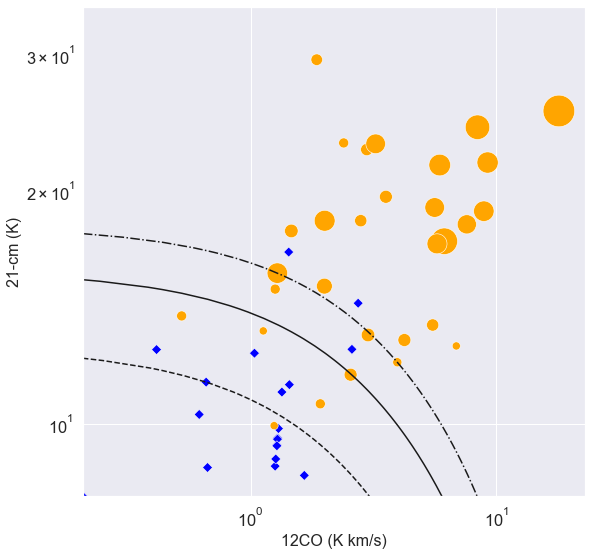

In [390]:
## import SVC
from sklearn.svm import SVC

## one with poly, degree=2, C = 10
svc_poly = SVC(kernel='poly', degree=3, C=10)
## one with rbf kernel, C = 10
svc_rbf = SVC(kernel = 'rbf', C=10)



proto_df = proto_df_imputed_inter.copy()
proto_df['proto'] = 2*np.array(proto_df['proto_flat_number'] > 0) - 1
print(proto_df.head(5))

X = np.array(proto_co_df[features])

x1 = np.linspace((X[:,0]).min(), X[:,0].max()+5, 100)
x2 = np.linspace((X[:,1]).min(), X[:,1].max()+5, 100)
X1X2 = np.concatenate([x1.reshape(-1,1),x2.reshape(-1,1)], axis=1)

X1X1, X2X2 = np.meshgrid(x1, x2)

# make a cleaner array
x1x2 = np.vstack([X1X1.ravel(), X2X2.ravel()]).T
#print(X.shape, x1x2.shape,X1X1.shape, svc_rbf.decision_function(x1x2).shape, y.shape)
#Zir = zir.predict(poly.fit_transform(x1x2))

# arrange them in a 2D grid
#X1X1, X2X2 = np.meshgrid(x1x1, x2x2)
#x1x2 = np.vstack([sc_X1.fit_transform(X1X1.ravel().reshape(-1,1)), sc_X2.fit_transform(X2X2.ravel().reshape(-1,1))]).T

#Z_rbf = svc_rbf.predict(x1x2.reshape(-1,2)).reshape(X1X1.shape)
#Z_rbf = svc_rbf.decision_function(x1x2).reshape(X1X1.shape)
y = np.array(proto_df['proto'])
svc_poly.fit(np.array(X),np.array(y).reshape(-1))
Z_rbf = svc_poly.decision_function(x1x2).reshape(X1X1.shape)

sns.set_style('darkgrid')
#fig,ax=plt.subplots(1,1,figsize=(7,7))
fig = plt.figure(figsize=(9,9))
sns.set(font_scale = 1.5)
#p = sns.lineplot(data = df)
#p.set_xlabel("X-Axis")
#p.set_ylabel("Y-Axis")
#sns.set_title("Plot")
sns.scatterplot(data = proto_df, x="12CO(K km/s)", y="21cm(K)", hue="proto", style = 'proto', 
                markers = ['D','o'], alpha = 1, size='proto_flat_number', sizes=(50, 1000), 
                palette=['blue','orange'], legend = False)
plt.contour(X1X1, X2X2, Z_rbf,colors='k', levels=[-1,0,1], 
                alpha=1, linestyles=['--','-','dashdot'])
#fig.colorbar(cp, label='FS proto number') # Add a colorbar to a plot
plt.xscale('log')
plt.yscale('log')
#ax.set_title('Zero Inflated Prediction', fontsize=14)
plt.xlabel('12CO (K km/s)', fontsize=16)
plt.ylabel('21-cm (K)', fontsize=16)
plt.savefig('co_21cm_ps.pdf')
plt.show()

<AxesSubplot:xlabel='12CO(K km/s)', ylabel='21cm(K)'>

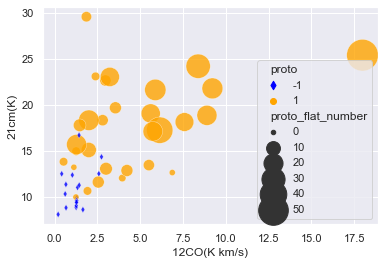

In [380]:
sns.scatterplot(data = proto_df, x="12CO(K km/s)", y="21cm(K)", hue="proto", style = 'proto', 
                markers = ['d','o'], alpha = 0.8, size='proto_flat_number', sizes=(20, 1000), 
                palette=['blue','orange'], legend = 'auto') 

In [340]:
from matplotlib import markers
# get all possible shapes
all_shapes = markers.MarkerStyle.markers.keys()
# print list of shapes
all_shapes

dict_keys(['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 'P', 'X', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 'None', None, ' ', ''])

# Zero inflated SVR: interaction considered 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(),
                                                       shuffle=True,
                                                       random_state=214,
                                                       stratify=y,
                                                       test_size=.2)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.